In [24]:
### given a few pairs of cointegrated coins, use Kalman filtering to calculate the moving slope and intercept between the two coins
# use moving slope and intercepts to calculate spread functions for the pairs
# use the spread functions to calculate points in the time series where spread is 1.96 SD above or below mean
# optional: use this strategy starting with imaginary 1k to plot equity over time. ###

In [25]:
# to get started right now, use stock prices from research paper as an example, insert crypto pairs later.
import tc_user_info
import bitfinex
import requests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import datetime
import time
import os
import zipfile
from pykalman import KalmanFilter
from sklearn.linear_model import LinearRegression
plt.style.use('seaborn-whitegrid')

In [26]:
# read in all the csv files from kaggle dataset of 478 crypto rates 
with zipfile.ZipFile('all_tickers.zip') as z:
    names = [i.upper().strip(".CSV") for i in z.namelist()]
    # dataframes = {filename.split(".")[0]: pd.read_csv(z.open(filename),header=None,encoding="utf8") for filename in names
names

['1INCH-USD',
 '1INCH-UST',
 'AAABBB',
 'AAVE-USD',
 'AAVE-UST',
 'ADABT',
 'ADAF0-USTF0',
 'ADAUSD',
 'ADAUST',
 'AIXUSD',
 'AIXUST',
 'ALBT-USD',
 'ALBT-UST',
 'ALGBT',
 'ALGUSD',
 'ALGUST',
 'AMPBT',
 'AMPF0-USTF0',
 'AMPUSD',
 'AMPUST',
 'ANCUSD',
 'ANCUST',
 'ANTBT',
 'ANTETH',
 'ANTUSD',
 'APEUSD',
 'APEUST',
 'APTUSD',
 'APTUST',
 'ASTUSD',
 'ATOBT',
 'ATOETH',
 'ATOUSD',
 'ATOUST',
 'AVAX-USD',
 'AVAX-UST',
 'AVTUSD',
 'AXSUSD',
 'AXSUST',
 'B21X-USD',
 'B21X-UST',
 'B2MUSD',
 'B2MUST',
 'BALUSD',
 'BALUST',
 'BAND-USD',
 'BAND-UST',
 'BATBT',
 'BATETH',
 'BATUSD',
 'BATUST',
 'BCHABC-USD',
 'BCHN-USD',
 'BEST-USD',
 'BFTUSD',
 'BMIUSD',
 'BMIUST',
 'BMNBT',
 'BMNUSD',
 'BNTUSD',
 'BOOUSD',
 'BOOUST',
 'BOSON-USD',
 'BOSON-UST',
 'BOXUSD',
 'BSVBT',
 'BSVUSD',
 'BTC-CNHT',
 'BTCDOMF0-USTF0',
 'BTCEUR',
 'BTCEUT',
 'BTCF0-USTF0',
 'BTCGBP',
 'BTCJPY',
 'BTCMIM',
 'BTCTRY',
 'BTCUSD',
 'BTCUST',
 'BTCXCH',
 'BTGBT',
 'BTGUSD',
 'BTSE-USD',
 'BTTUSD',
 'DBT',
 'DUSD',
 'DUST',
 'E

In [15]:
df = dataframes["etpusd"]
df.columns = df.iloc[0]
df = df.drop(0)
df = df.set_index("time")[["close"]]
df.iloc[-525600:]

,time_period_start,time_period_end,time_open,rate_open,rate_high,rate_low,rate_close
time_close,,,,,,,
2022-11-21 00:00:00+00:00,2022-11-21T00:00:00.0000000Z,2022-11-21T00:01:00.0000000Z,2022-11-21T00:00:00.0000000Z,16256.189979,16256.189979,16256.189979,16256.189979
2022-11-21 00:01:00+00:00,2022-11-21T00:01:00.0000000Z,2022-11-21T00:02:00.0000000Z,2022-11-21T00:01:00.0000000Z,16264.915625,16264.915625,16264.915625,16264.915625
2022-11-21 00:02:00+00:00,2022-11-21T00:02:00.0000000Z,2022-11-21T00:03:00.0000000Z,2022-11-21T00:02:00.0000000Z,16253.132224,16253.132224,16253.132224,16253.132224
2022-11-21 00:03:00+00:00,2022-11-21T00:03:00.0000000Z,2022-11-21T00:04:00.0000000Z,2022-11-21T00:03:00.0000000Z,16245.517644,16245.517644,16245.517644,16245.517644
2022-11-21 00:04:00+00:00,2022-11-21T00:04:00.0000000Z,2022-11-21T00:05:00.0000000Z,2022-11-21T00:04:00.0000000Z,16234.319268,16234.319268,16234.319268,16234.319268
...,...,...,...,...,...,...,...
2022-11-21 16:35:00+00:00,2022-11-21T16:35:00.0000000Z,2022-11-21T16:36:00.0000000Z,2022-11-21T16:35:00.0000000Z,15941.185836,15941.185836,15941.185836,15941.185836
2022-11-21 16:36:00+00:00,2022-11-21T16:36:00.0000000Z,2022-11-21T16:37:00.0000000Z,2022-11-21T16:36:00.0000000Z,15970.331276,15970.331276,15970.331276,15970.331276
2022-11-21 16:37:00+00:00,2022-11-21T16:37:00.0000000Z,2022-11-21T16:38:00.0000000Z,2022-11-21T16:37:00.0000000Z,15960.543539,15960.543539,15960.543539,15960.543539


In [ ]:
mainDf = dataframes["btcusd"]
mainDf.columns = mainDf.iloc[0]
mainDf = mainDf.drop(0).iloc[-525600:].set_index("time")[["close"]].rename(columns = {"close": "btcusd"})
# for i in dataframes:
#     df = dataframes[i]
#     df.columns = df.iloc[0]
#     df = df.drop(0)
#     if df.shape[0] >= 525600:
#         closes = df.iloc[-525600:]["close"].astype("string")
#         nan_prop = np.count_nonzero(closes.str.contains("NaN"))/525600
#         print(nan_prop)
#         if i != "btcusd" and nan_prop < 0.1:
#             print(i)
#             df = df.set_index("time")[["close"]].rename(columns = {"close": i})
#             mainDf = mainDf.join(df, how = "left")
mainDf

In [27]:
def fetch_data(start=1364767200000, stop=1545346740000, symbol='btcusd', interval='1m', tick_limit=1000, step=60000000):
    # Create api instance
    api_v2 = bitfinex.bitfinex_v2.api_v2()

    data = []
    start = start - step
    while start < stop:

        start = start + step
        end = start + step
        res = api_v2.candles(symbol=symbol, interval=interval, limit=tick_limit, start=start, end=end)
        data.extend(res)
        print('Retrieving data from {} to {} for {}'.format(pd.to_datetime(start, unit='ms'),
                                                            pd.to_datetime(end, unit='ms'), symbol))
        time.sleep(1.5)
    return data

In [28]:
def fetch_all_data(assetList,resolution):
    dfs=[]
    for coin in assetList:
        bin_size = resolution # This is the resolution at which we request the data
        limit = 1000 # How many data points per call are we asking for
        time_step = 1000 * 60 * limit # From the above calulate the size of each sub querry
        # Fill in the start and end time of interest and convert it to timestamps
        t_start = datetime.datetime(2022, 1, 1, 0, 0)
        t_start = time.mktime(t_start.timetuple()) * 1000
        print(t_start)

        t_stop = datetime.datetime(2022, 11, 24, 23, 59)
        t_stop = time.mktime(t_stop.timetuple()) * 1000

        # Create an bitfinex_api instance
        api_v1 = bitfinex.bitfinex_v1.api_v1()
        pair_data = fetch_data(start=t_start, stop=t_stop, symbol=coin, interval=bin_size, tick_limit=limit, step=time_step)
        ind = [np.ndim(x) != 0 for x in pair_data]
        pair_data = [i for (i, v) in zip(pair_data, ind) if v]

        # Create pandas data frame and clean data
        names = ['time', 'open', 'close', 'high', 'low', 'volume']
        df = pd.DataFrame(pair_data, columns=names)
        df.drop_duplicates(inplace=True)
        df.set_index('time', inplace=True)
        df.sort_index(inplace=True)
        df.index = pd.to_datetime(df.index, unit='ms')
        df.to_csv(f'1yr_{coin}.csv')
        dfs.append(df)
    return dfs

In [29]:
dfs = fetch_all_data(["XRPUSD","ZECUSD"],"1m")

1641024000000.0
No keys, only access to public API functions
No keys, only access to public API functions
Retrieving data from 2022-01-01 08:00:00 to 2022-01-02 00:40:00 for XRPUSD
Retrieving data from 2022-01-02 00:40:00 to 2022-01-02 17:20:00 for XRPUSD
Retrieving data from 2022-01-02 17:20:00 to 2022-01-03 10:00:00 for XRPUSD
Retrieving data from 2022-01-03 10:00:00 to 2022-01-04 02:40:00 for XRPUSD
Retrieving data from 2022-01-04 02:40:00 to 2022-01-04 19:20:00 for XRPUSD
Retrieving data from 2022-01-04 19:20:00 to 2022-01-05 12:00:00 for XRPUSD
Retrieving data from 2022-01-05 12:00:00 to 2022-01-06 04:40:00 for XRPUSD
Retrieving data from 2022-01-06 04:40:00 to 2022-01-06 21:20:00 for XRPUSD
Retrieving data from 2022-01-06 21:20:00 to 2022-01-07 14:00:00 for XRPUSD
Retrieving data from 2022-01-07 14:00:00 to 2022-01-08 06:40:00 for XRPUSD
Retrieving data from 2022-01-08 06:40:00 to 2022-01-08 23:20:00 for XRPUSD
Retrieving data from 2022-01-08 23:20:00 to 2022-01-09 16:00:00 for X

471838


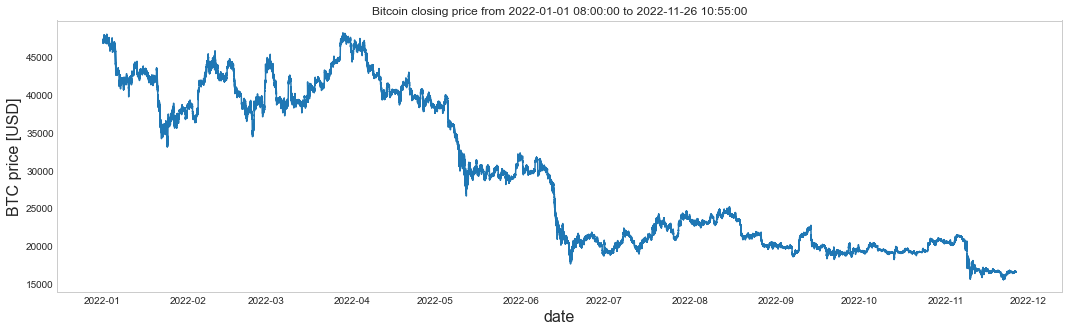

In [16]:
df = dfs[0]
print(df.shape[0])

fig, ax = plt.subplots(1, 1, figsize=(18, 5))

ax.plot(df['close'])
ax.set_xlabel('date', fontsize=16)
ax.set_ylabel('BTC price [USD]', fontsize=16)
ax.set_title('Bitcoin closing price from {} to {}'.format(df.index[0], df.index[-1]))
ax.grid()

plt.show()